In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import resample
from sklearn.utils import shuffle
pr_temp = pd.read_csv('words_results.csv')
pr_temp = pr_temp.sample(frac = 1)

data_majority = pr_temp[pr_temp["result"] == 0]
data_minority = pr_temp[pr_temp["result"] == 1]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority,
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
data_upsampled = shuffle(data_upsampled)

data_upsampled = data_upsampled[['word', 'result']]

majority class before upsample: (1681, 6)
minority class before upsample: (551, 6)


In [ ]:
data_upsampled

,word,result
66,P F P P P P P F x x w w x w x x w x x x x x U ...,0
1416,w x w x w x x x w x x x x P P P F F P P P x z ...,1
1818,x x x w x P F P P P F P P x x x w x x w x x y ...,0
1325,P P P P F F P P x x w x x w x x x w x x x x S ...,1
691,F P P P P P P F x x x w x x x w x x x x x x S ...,0
...,...,...
1360,x x x x x x x w x x P P F P F P P F P P P P y ...,0
2083,F F P P P P P P x x x x w x w x x x x w w w z ...,1
990,x x x x P P P P F F P P x x x x x w w x x w U ...,0
1813,F P P P F P P P F P P x x x x w x x x x x x z ...,0


In [ ]:
!pip install gensim numpy

In [ ]:
from gensim.models import Word2Vec

# Example tokenized sentences (replace with your actual data)
candidate_words = [
    'produced', 'similar','possibly', 'obtained','accordance',
    'valid', 'match', 'mismatch', 'align','equal','uneven', 'according',
    'discrepancy', 'incompatible', 'concurrent',
    'pass','dissidence','dissimilation','disparity','misfit'
]

import torch
from transformers import BertModel, BertTokenizer
from scipy.spatial.distance import cosine

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

def get_word_embedding(word):
    # Tokenize the word and convert it to input tensors with padding and truncation
    inputs = tokenizer(word, return_tensors='pt', padding=True, truncation=True)

    # Get the hidden states from BERT
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the embeddings for all tokens from the final hidden layer
    hidden_states = outputs.hidden_states
    token_embeddings = hidden_states[-1].squeeze()

    # Get the embedding for the first token (corresponds to the input word)
    word_embedding = token_embeddings.mean(dim=0)

    return word_embedding

# # Example candidate words to compare (you can use words from your dataset or corpus)
# candidate_words = [
#     'compatible', 'unhelpful', 'helpful', 'team', 'game', 'discrepancy',
#     'agreement', 'unmatched', 'incompatible', 'alignment', 'harmony', 'conflict'
# ]

# Get the embeddings for the target words 'match' and 'mismatch'
match_embedding = get_word_embedding('match')
mismatch_embedding = get_word_embedding('mismatch')

# Calculate cosine similarity for each candidate word with 'match' and 'mismatch'
def get_similar_words(target_embedding, candidate_words, top_n=6):
    similarities = []
    for word in candidate_words:
        candidate_embedding = get_word_embedding(word)
        similarity = 1 - cosine(target_embedding.numpy(), candidate_embedding.numpy())
        similarities.append((word, similarity))

    # Sort by highest similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    return similarities[:top_n]

# Get 6 most related words for 'match'
related_to_match = get_similar_words(match_embedding, candidate_words, top_n=20)
print(f"Top words related to 'match': {[word for word, sim in related_to_match]}")

# Get 6 most related words for 'mismatch'
related_to_mismatch = get_similar_words(mismatch_embedding, candidate_words, top_n=20)
print(f"Top words related to 'mismatch': {[word for word, sim in related_to_mismatch]}")

print(f"'match': {[sim for word, sim in related_to_match]}")

# Get 6 most related words for 'mismatch'
related_to_mismatch = get_similar_words(mismatch_embedding, candidate_words, top_n=20)
print(f"'mismatch': {[sim for word, sim in related_to_mismatch]}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Top words related to 'match': ['match', 'pass', 'obtained', 'align', 'equal', 'produced', 'incompatible', 'possibly', 'valid', 'uneven', 'accordance', 'similar', 'according', 'mismatch', 'disparity', 'concurrent', 'discrepancy', 'misfit', 'dissidence', 'dissimilation']
Top words related to 'mismatch': ['mismatch', 'dissidence', 'discrepancy', 'dissimilation', 'disparity', 'misfit', 'concurrent', 'match', 'pass', 'incompatible', 'equal', 'similar', 'align', 'possibly', 'obtained', 'produced', 'uneven', 'accordance', 'valid', 'according']
'match': [0.9999999833353024, 0.6879069003819074, 0.6311738200938307, 0.6211274793476695, 0.6136714273507019, 0.6128643647441655, 0.6104346505019624, 0.5851080063591497, 0.5844942633034597, 0.5818406933945681, 0.5812516984506386, 0.579762615401898, 0.5664209545314927, 0.5521265492165, 0.5520911118455328, 0.5411496885293146, 0.5082736372365215, 0.4824761977240173, 0.4322350389131757, 0.43123563822659605]
'mismatch': [1.0, 0.635740655533803, 0.62653943705

In [ ]:
new_row_df = pd.DataFrame(columns=['word','result'])

#'match', 'pass', 'obtained', 'align', 'equal', 'produced'
#'mismatch', 'dissidence', 'discrepancy', 'dissimilation', 'disparity', 'misfit'


for index, row in data_upsampled.iterrows():
  word = row['word']
  result = row['result']
  changed_sentence = ''
  sentence = ''

  for i in range(len(word)):
    if word[i] == 'w':
      sentence = sentence+'equal'
      changed_sentence = changed_sentence+'equal'
    elif word[i] == 'x':
      sentence = sentence+'disparity'
      changed_sentence = changed_sentence+'disparity'
    elif word[i] == 'P':
      sentence = sentence+'obtained'
      changed_sentence = changed_sentence+'align'
    elif word[i] == 'F':
      sentence = sentence+'discrepancy'
      changed_sentence = changed_sentence+'dissimilation'
    elif word[i] == 'y':
      sentence = sentence+'produced'
      changed_sentence = changed_sentence+'produced'
    elif word[i] == 'z':
      sentence = sentence+'misfit'
      changed_sentence = changed_sentence+'misfit'
    elif word[i] == 'S':
      sentence = sentence+'match'
      changed_sentence = changed_sentence+'pass'
    elif word[i] == 'U':
      sentence = sentence+'mismatch'
      changed_sentence = changed_sentence+'dissidence'
    elif word[i] == ' ':
      sentence = sentence+' '
      changed_sentence = changed_sentence+' '

  data_upsampled.at[index, 'word'] = changed_sentence

  new_row = pd.DataFrame({'word': changed_sentence,'result':[result]})
  new_row_df = pd.concat([new_row_df, new_row], ignore_index=True)

data_upsampled = pd.concat([data_upsampled, new_row_df], ignore_index=True)

data_upsampled = data_upsampled.sample(frac = 1)
data_upsampled

,word,result
2011,align align dissimilation dissimilation dissim...,0
97,align align align align dissimilation align al...,0
3710,disparity disparity disparity equal disparity ...,0
3708,align align align dissimilation align align di...,0
5535,align dissimilation align align align dissimil...,0
...,...,...
2207,align align dissimilation align align align di...,0
1641,align align align align align align align diss...,0
3857,align align align dissimilation dissimilation ...,1
4658,align align align align dissimilation dissimil...,1


In [ ]:
X_data = data_upsampled[['word']]
Y_data = data_upsampled[['result']]

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold, train_test_split
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import numpy as np


# Step 1: Split data into train/hold-out test before cross-validation
sentence = X_data['word'].tolist()
Y_data['result'] = Y_data['result'].astype(int)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_data = tokenizer(
        sentence,  # First column
        padding='max_length',
        truncation=True,
        max_length=120,  # Set according to your max sentence length
        return_tensors='pt'  # Return PyTorch tensors
    )

input_ids = tokenized_data['input_ids']
attention_masks = tokenized_data['attention_mask']


<ipython-input-10-539c499afb77>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_data['result'] = Y_data['result'].astype(int)
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
len(input_ids)

6724

In [ ]:
X_data

,word
2011,align align dissimilation dissimilation dissim...
97,align align align align dissimilation align al...
3710,disparity disparity disparity equal disparity ...
3708,align align align dissimilation align align di...
5535,align dissimilation align align align dissimil...
...,...
2207,align align dissimilation align align align di...
1641,align align align align align align align diss...
3857,align align align dissimilation dissimilation ...
4658,align align align align dissimilation dissimil...


In [ ]:
X_data.loc[0, 'word']

'align dissimilation align align align align align dissimilation disparity disparity equal equal disparity equal disparity disparity equal disparity disparity disparity disparity disparity dissidence pass pass pass pass dissidence pass pass pass pass dissidence misfit misfit misfit misfit misfit misfit produced produced misfit produced misfit'

In [ ]:
import pandas as pd # Import pandas for DataFrame creation

# Convert the 'input_ids' and 'attention_mask' to DataFrames
input_ids_df = pd.DataFrame(tokenized_data['input_ids'].numpy())
attention_masks_df = pd.DataFrame(tokenized_data['attention_mask'].numpy())

# Concatenate the DataFrames if you want them in a single CSV
combined_df = pd.concat([input_ids_df, attention_masks_df], axis=1)

# Save to CSV
combined_df.to_csv('tokenized_data.csv', index=False)


Starting Fold 1/5
Layer (type:depth-idx)                   Param #
AttentionBiLSTM                          --
├─Embedding: 1-1                         3,906,816
├─LSTM: 1-2                              99,328
├─Attention: 1-3                         --
│    └─Linear: 2-1                       129
├─Linear: 1-4                            129
├─Dropout: 1-5                           --
Total params: 4,006,402
Trainable params: 4,006,402
Non-trainable params: 0
Epoch 1/250 - Train Acc: 0.5045 - Val Acc: 0.5177  - LR: 0.00040000
Epoch 2/250 - Train Acc: 0.5229 - Val Acc: 0.5223  - LR: 0.00040000
Epoch 3/250 - Train Acc: 0.5361 - Val Acc: 0.5474  - LR: 0.00040000
Epoch 4/250 - Train Acc: 0.5701 - Val Acc: 0.5623  - LR: 0.00040000
Epoch 5/250 - Train Acc: 0.5791 - Val Acc: 0.5353  - LR: 0.00040000
Epoch 6/250 - Train Acc: 0.5868 - Val Acc: 0.5595  - LR: 0.00040000
Epoch 7/250 - Train Acc: 0.5973 - Val Acc: 0.5929  - LR: 0.00040000
Epoch 8/250 - Train Acc: 0.6107 - Val Acc: 0.5641  - LR: 0.

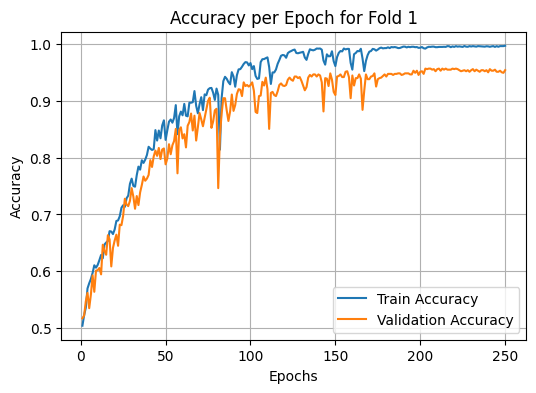


Starting Fold 2/5
Layer (type:depth-idx)                   Param #
AttentionBiLSTM                          --
├─Embedding: 1-1                         3,906,816
├─LSTM: 1-2                              99,328
├─Attention: 1-3                         --
│    └─Linear: 2-1                       129
├─Linear: 1-4                            129
├─Dropout: 1-5                           --
Total params: 4,006,402
Trainable params: 4,006,402
Non-trainable params: 0
Epoch 1/250 - Train Acc: 0.5120 - Val Acc: 0.5093  - LR: 0.00040000
Epoch 2/250 - Train Acc: 0.5229 - Val Acc: 0.5353  - LR: 0.00040000
Epoch 3/250 - Train Acc: 0.5568 - Val Acc: 0.5520  - LR: 0.00040000
Epoch 4/250 - Train Acc: 0.5652 - Val Acc: 0.5855  - LR: 0.00040000
Epoch 5/250 - Train Acc: 0.5661 - Val Acc: 0.6022  - LR: 0.00040000
Epoch 6/250 - Train Acc: 0.5838 - Val Acc: 0.5911  - LR: 0.00040000
Epoch 7/250 - Train Acc: 0.5947 - Val Acc: 0.5911  - LR: 0.00040000
Epoch 8/250 - Train Acc: 0.5996 - Val Acc: 0.6106  - LR: 0.

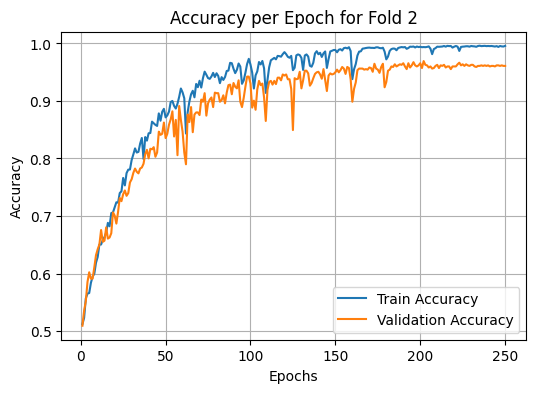


Starting Fold 3/5
Layer (type:depth-idx)                   Param #
AttentionBiLSTM                          --
├─Embedding: 1-1                         3,906,816
├─LSTM: 1-2                              99,328
├─Attention: 1-3                         --
│    └─Linear: 2-1                       129
├─Linear: 1-4                            129
├─Dropout: 1-5                           --
Total params: 4,006,402
Trainable params: 4,006,402
Non-trainable params: 0
Epoch 1/250 - Train Acc: 0.5124 - Val Acc: 0.5651  - LR: 0.00040000
Epoch 2/250 - Train Acc: 0.5387 - Val Acc: 0.5548  - LR: 0.00040000
Epoch 3/250 - Train Acc: 0.5605 - Val Acc: 0.5530  - LR: 0.00040000
Epoch 4/250 - Train Acc: 0.5619 - Val Acc: 0.5734  - LR: 0.00040000
Epoch 5/250 - Train Acc: 0.5854 - Val Acc: 0.5827  - LR: 0.00040000
Epoch 6/250 - Train Acc: 0.5884 - Val Acc: 0.5725  - LR: 0.00040000
Epoch 7/250 - Train Acc: 0.5975 - Val Acc: 0.5725  - LR: 0.00040000
Epoch 8/250 - Train Acc: 0.6121 - Val Acc: 0.6180  - LR: 0.

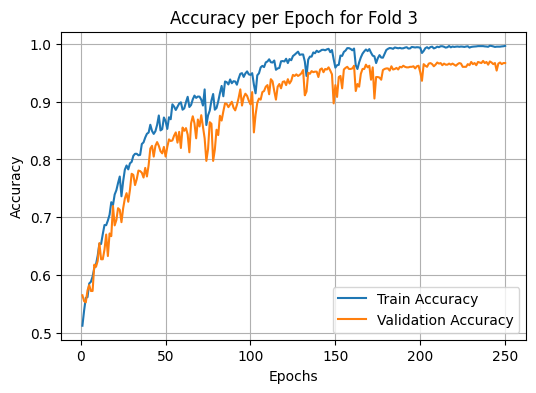


Starting Fold 4/5
Layer (type:depth-idx)                   Param #
AttentionBiLSTM                          --
├─Embedding: 1-1                         3,906,816
├─LSTM: 1-2                              99,328
├─Attention: 1-3                         --
│    └─Linear: 2-1                       129
├─Linear: 1-4                            129
├─Dropout: 1-5                           --
Total params: 4,006,402
Trainable params: 4,006,402
Non-trainable params: 0
Epoch 1/250 - Train Acc: 0.5182 - Val Acc: 0.5716  - LR: 0.00040000
Epoch 2/250 - Train Acc: 0.5136 - Val Acc: 0.5195  - LR: 0.00040000
Epoch 3/250 - Train Acc: 0.5306 - Val Acc: 0.5623  - LR: 0.00040000
Epoch 4/250 - Train Acc: 0.5464 - Val Acc: 0.5734  - LR: 0.00040000
Epoch 5/250 - Train Acc: 0.5598 - Val Acc: 0.6152  - LR: 0.00040000
Epoch 6/250 - Train Acc: 0.5768 - Val Acc: 0.5901  - LR: 0.00040000
Epoch 7/250 - Train Acc: 0.5889 - Val Acc: 0.5985  - LR: 0.00040000
Epoch 8/250 - Train Acc: 0.6017 - Val Acc: 0.5939  - LR: 0.

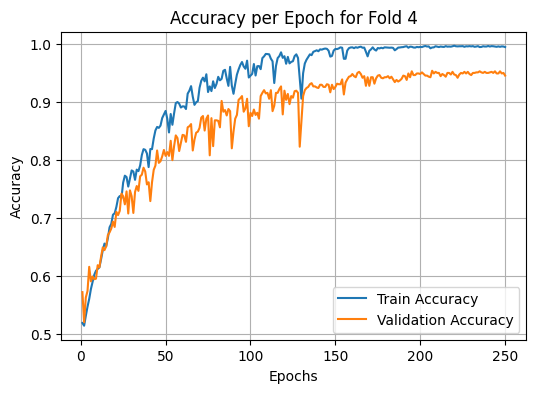


Starting Fold 5/5
Layer (type:depth-idx)                   Param #
AttentionBiLSTM                          --
├─Embedding: 1-1                         3,906,816
├─LSTM: 1-2                              99,328
├─Attention: 1-3                         --
│    └─Linear: 2-1                       129
├─Linear: 1-4                            129
├─Dropout: 1-5                           --
Total params: 4,006,402
Trainable params: 4,006,402
Non-trainable params: 0
Epoch 1/250 - Train Acc: 0.5077 - Val Acc: 0.5088  - LR: 0.00040000
Epoch 2/250 - Train Acc: 0.5448 - Val Acc: 0.5274  - LR: 0.00040000
Epoch 3/250 - Train Acc: 0.5639 - Val Acc: 0.5535  - LR: 0.00040000
Epoch 4/250 - Train Acc: 0.5788 - Val Acc: 0.5460  - LR: 0.00040000
Epoch 5/250 - Train Acc: 0.5890 - Val Acc: 0.5777  - LR: 0.00040000
Epoch 6/250 - Train Acc: 0.5885 - Val Acc: 0.5749  - LR: 0.00040000
Epoch 7/250 - Train Acc: 0.5978 - Val Acc: 0.5767  - LR: 0.00040000
Epoch 8/250 - Train Acc: 0.5983 - Val Acc: 0.5777  - LR: 0.

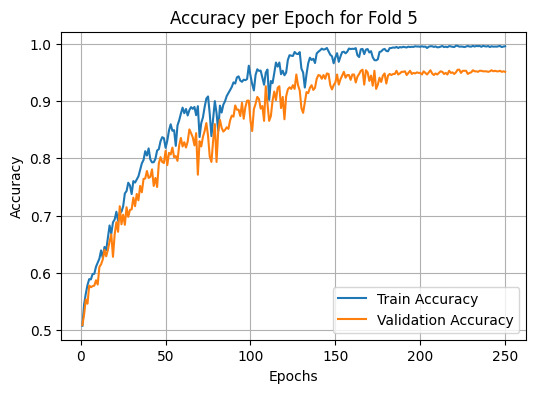


Mean and Standard Deviation of Metrics:
Validation Accuracy: 0.878 ± 0.009
Sensitivity: 0.980 ± 0.013
Specificity: 0.931 ± 0.008
Test Accuracy: 0.956 ± 0.003
Sensitivity: 0.986 ± 0.006
Specificity: 0.925 ± 0.003


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import BertModel, BertTokenizer


# Initialize parameters
batch_size = 32
test_size = 0.2
num_epochs = 250
embedding_dim = 128
hidden_size = 64
lr = 0.0004
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output):
        attention_weights = torch.tanh(self.attn(lstm_output))
        attention_weights = torch.softmax(attention_weights, dim=1)
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector, attention_weights


class AttentionBiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, vocab_size):
        super(AttentionBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)
        lstm_output, _ = self.bilstm(embedded)
        context_vector, attention_weights = self.attention(lstm_output)
        output = self.fc(self.dropout(context_vector))
        return output


X_train_ids, X_test_ids, X_train_masks, X_test_masks, Y_train, Y_test = train_test_split(
    input_ids, attention_masks, Y_data, test_size=test_size, random_state=42
)

# Step 2: Dataset class remains the same
class BertDataset(Dataset):
    def __init__(self, X_ids, X_masks, Y):
        self.X_ids = X_ids
        self.X_masks = X_masks
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return {
            'input_ids': self.X_ids[idx],
            'attention_mask': self.X_masks[idx],
            'labels': self.Y[idx]
        }

# Step 3: 5-Fold Cross-Validation Setup
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize test dataset for later testing
test_dataset = BertDataset(X_test_ids, X_test_masks, torch.tensor(Y_test['result'].values, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Store accuracies for all folds
all_train_accuracies = []
all_val_accuracies = []
all_test_accuracies = []
all_sensitivities = []
all_specificities = []
all_val_sensitivities = []
all_val_specificities = []


for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_ids)):
    print(f"\nStarting Fold {fold + 1}/{k_folds}")

    # Split train/val based on fold indices
    train_dataset = Subset(BertDataset(X_train_ids, X_train_masks, torch.tensor(Y_train['result'].values, dtype=torch.long)), train_idx)
    val_dataset = Subset(BertDataset(X_train_ids, X_train_masks, torch.tensor(Y_train['result'].values, dtype=torch.long)), val_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and loss function
    model = AttentionBiLSTM(embedding_dim=embedding_dim, hidden_dim=hidden_size, output_dim=1, vocab_size=tokenizer.vocab_size)
    #model.summary()  # Print the summary at the beginning of each fold
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.7, patience=10,min_lr=0.00000625)
    print(summary(model))

    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_preds = 0
        total_preds = 0

        for batch in train_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels'].unsqueeze(1).float()

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predictions = torch.round(torch.sigmoid(outputs))
            correct_preds += (predictions == labels).sum().item()
            total_preds += labels.size(0)

        train_accuracy = correct_preds / total_preds
        train_accuracies.append(train_accuracy)
        train_loss = total_loss / len(train_loader)

        # Validation after each epoch
        model.eval()
        correct_preds = 0
        total_preds = 0
        total_loss_val = 0
        val_true_positives = 0
        val_false_positives = 0
        val_true_negatives = 0
        val_false_negatives = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels'].unsqueeze(1).float()
                outputs = model(input_ids, attention_mask)
                predictions = torch.round(torch.sigmoid(outputs))

                correct_preds += (predictions == labels).sum().item()
                total_preds += labels.size(0)

                val_true_positives += ((predictions == 1) & (labels == 1)).sum().item()
                val_false_positives += ((predictions == 1) & (labels == 0)).sum().item()
                val_true_negatives += ((predictions == 0) & (labels == 0)).sum().item()
                val_false_negatives += ((predictions == 0) & (labels == 1)).sum().item()

        val_accuracy = correct_preds / total_preds
        val_accuracies.append(val_accuracy)
        val_sensitivity = val_true_positives / (val_true_positives + val_false_negatives) if (val_true_positives + val_false_negatives) > 0 else 0
        val_specificity = val_true_negatives / (val_true_negatives + val_false_positives) if (val_true_negatives + val_false_positives) > 0 else 0


        scheduler.step(val_accuracy)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Acc: {train_accuracy:.4f} - Val Acc: {val_accuracy:.4f}  - LR: {current_lr:.8f}")

    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)
    all_val_sensitivities.append(val_sensitivity)
    all_val_specificities.append(val_specificity)

    # Step 4: Evaluate on the hold-out test data at the end of each fold
    model.eval()
    correct_preds = 0
    total_preds = 0
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels'].unsqueeze(1).float()

            outputs = model(input_ids, attention_mask)
            predictions = torch.round(torch.sigmoid(outputs))
            correct_preds += (predictions == labels).sum().item()
            total_preds += labels.size(0)

            # Calculate sensitivity and specificity
            true_positives += ((predictions == 1) & (labels == 1)).sum().item()
            false_positives += ((predictions == 1) & (labels == 0)).sum().item()
            true_negatives += ((predictions == 0) & (labels == 0)).sum().item()
            false_negatives += ((predictions == 0) & (labels == 1)).sum().item()

    test_accuracy = correct_preds / total_preds
    test_sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    test_specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0

    all_test_accuracies.append(test_accuracy)
    all_sensitivities.append(test_sensitivity)
    all_specificities.append(test_specificity)


    print(f"Test Accuracy on hold-out set for Fold {fold + 1}: {test_accuracy:.3f}")
    print(f"Sensitivity: {test_sensitivity:.3f}, Specificity: {test_specificity:.3f}")

    # Plot epoch accuracy for this fold
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.title(f'Accuracy per Epoch for Fold {fold + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Step 5: Print the mean and std of validation and test metrics
mean_val_accuracy = np.mean([np.mean(val) for val in all_val_accuracies])
std_val_accuracy = np.std([np.mean(val) for val in all_val_accuracies])
mean_val_sensitivity = np.mean(all_val_sensitivities)
std_val_sensitivity = np.std(all_val_sensitivities)
mean_val_specificity = np.mean(all_val_specificities)
std_val_specificity = np.std(all_val_specificities)

mean_test_accuracy = np.mean(all_test_accuracies)
std_test_accuracy = np.std(all_test_accuracies)
mean_sensitivity = np.mean(all_sensitivities)
std_sensitivity = np.std(all_sensitivities)
mean_specificity = np.mean(all_specificities)
std_specificity = np.std(all_specificities)

print("\nMean and Standard Deviation of Metrics:")

print(f"Validation Accuracy: {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Sensitivity: {mean_val_sensitivity:.3f} ± {std_val_sensitivity:.3f}")
print(f"Specificity: {mean_val_specificity:.3f} ± {std_val_specificity:.3f}")

print(f"Test Accuracy: {mean_test_accuracy:.3f} ± {std_test_accuracy:.3f}")
print(f"Sensitivity: {mean_sensitivity:.3f} ± {std_sensitivity:.3f}")
print(f"Specificity: {mean_specificity:.3f} ± {std_specificity:.3f}")


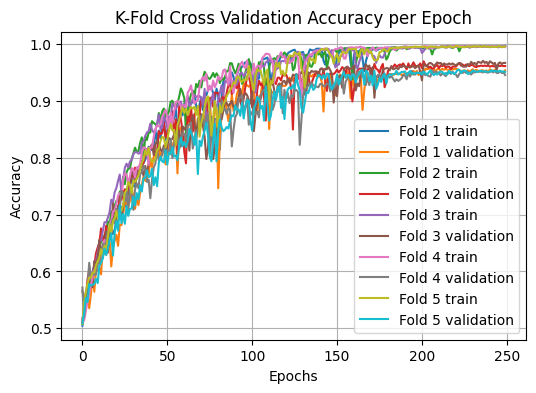

In [ ]:
plt.figure(figsize=(6, 4))
for i in range(len(all_val_accuracies)):
  plt.plot(np.arange(0, 250), all_train_accuracies[i], label=f'Fold {i + 1} train')
  plt.plot(np.arange(0, 250), all_val_accuracies[i], label=f'Fold {i + 1} validation')


plt.title('K-Fold Cross Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.xticks(np.arange(1, 200))
plt.legend()
plt.grid()
plt.show()

In [ ]:
means = 0
for accs in all_val_accuracies:
  print(np.mean(accs[150:]),'\n')
  means += np.mean(accs)
means/=5
print('mean: ',means)

0.9475371747211895 

0.9575836431226764 

0.9575557620817844 

0.9448234200743494 

0.9471813953488372 

mean:  0.8780971563931874


In [ ]:
import numpy as np
mean_arr = [0.9475371747211895, 0.9575836431226764, 0.9575557620817844, 0.9448234200743494, 0.9471813953488372]
print(np.mean(mean_arr),'\n')
print(np.std(mean_arr),'\n')

0.9509362790697674 

0.005495909595806313 



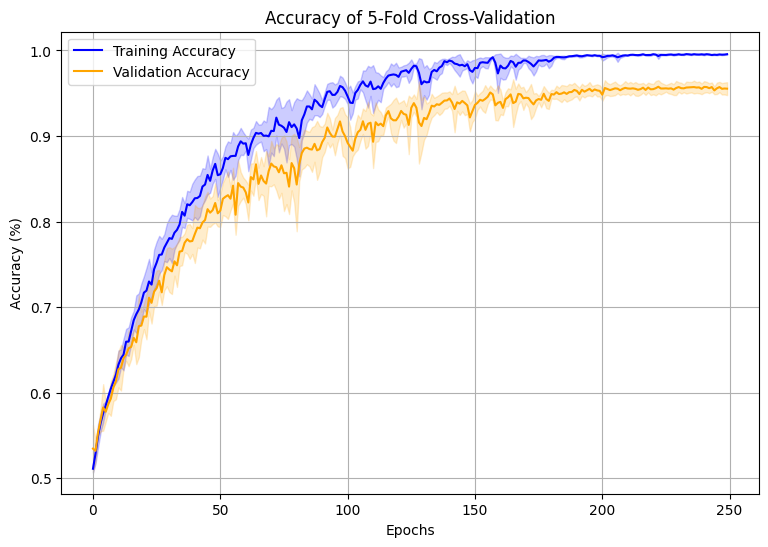

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data: Replace these with your actual accuracy arrays
# Assuming you have 5 folds and 10 epochs
num_folds = 5
num_epochs = 250


# Calculate mean and standard deviation for training and validation accuracies
train_mean = np.mean(all_train_accuracies, axis = 0)
train_std = np.std(all_train_accuracies, axis = 0)
val_mean = np.mean(all_val_accuracies, axis = 0)
val_std = np.std(all_val_accuracies, axis = 0)

# Create the plot
plt.figure(figsize=(9, 6))

# Plot training accuracy with error bars
plt.plot(train_mean, label='Training Accuracy', color='blue')
plt.fill_between(np.arange(num_epochs), train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)

# Plot validation accuracy with error bars
plt.plot(val_mean, label='Validation Accuracy', color='orange')
plt.fill_between(np.arange(num_epochs), val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)

# Add titles and labels
plt.title('Accuracy of 5-Fold Cross-Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
# Show the plot
plt.show()